In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('train_transaction.csv')

In [3]:
df_id = pd.read_csv('train_identity.csv')

In [4]:
df = pd.merge(df, df_id, how='left', on='TransactionID')

In [5]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [6]:
sketchy_devices = list(df.groupby('DeviceInfo').isFraud.agg([np.mean, len]).query('len>10').query('mean>.5').index)

In [7]:
sketchy_browser = list(df.groupby('id_31').isFraud.agg([np.mean, len]).query('len>10').query('mean>.15').index)

In [8]:
#Dealing with NA
df.fillna(0, inplace=True)
#Variable Creation
df['has_r'] = (pd.notna(df['R_emaildomain'])).astype(int)
df['different_r'] = (df['has_r']) * (df.P_emaildomain == df.R_emaildomain).astype(int)
df['is_discover'] = (df.card4=='discover').astype(int)
df['is_credit'] = (df.card6=='credit').astype(int)
df['is_sketchy_addr2'] = (df.addr2.isin([0,60,96]))
df['is_na_M1'] = (df['M1']==0).astype(int)
df['is_na_M2'] = (df['M2']==0).astype(int)
df['is_na_M3'] = (df['M3']==0).astype(int)
df['is_na_M5'] = (df['M5']==0).astype(int)
df['is_na_M6'] = (df['M6']==0).astype(int)
df['is_na_M7'] = (df['M7']==0).astype(int)
df['is_na_M8'] = (df['M8']==0).astype(int)
df['is_na_M9'] = (df['M9']==0).astype(int)
df['is_big_NA'] = df['is_na_M1']*df['is_na_M2']*df['is_na_M3']*df['is_na_M5']*df['is_na_M6']*df['is_na_M7']*df['is_na_M8']*df['is_na_M9']
df['is_C'] = (df.ProductCD=='C').astype(int)
df['is_S'] = (df.ProductCD=='S').astype(int)
df['is_H'] = (df.ProductCD=='H').astype(int)
df['is_mobile'] = (df.DeviceType=='mobile').astype(int)
df['is_sketchy_device'] = (df.DeviceInfo.isin(sketchy_devices)).astype(int)
df['is_sketchy_browser'] = (df.id_31.isin(sketchy_browser)).astype(int)
df['is_protonmail'] = (df.P_emaildomain=='protonmail.com').astype(int)
df['is_elsewise_sketchy_email'] = (df.P_emaildomain.isin(['mail.com', 'outlook.es', 'aim.com', 'outlook.com']))
df['is_match'] = (df.id_34=='match_status:1').astype(int)
df['is_M4M2'] = (df['M4']=='M2').astype(int)
df['is_M3'] = (df['M3']=='T').astype(int)
df['is_M2'] = (df['M2']=='T').astype(int)
df['is_M9'] = (df['M9']=='T').astype(int)
df['is_no_info'] = (df.DeviceType==0).astype(int)


In [17]:
pcaCols = list(df.columns[pd.Series(df.columns).apply(lambda x: x[0]=='V')])

In [11]:
from sklearn.decomposition import PCA

In [12]:
pca1 = PCA()

In [18]:
pca1.fit(df[pcaCols])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [21]:
tng = pca1.explained_variance_ratio_

In [101]:
sum(tng[0:40])

0.999991390249288

In [102]:
smaller_v = pd.DataFrame(pca1.transform(df[pcaCols])[:, 0:40])

In [103]:
smaller_v.columns = ['pca_'+str(a) for a in smaller_v.columns]

In [104]:
df2 = pd.concat([df, smaller_v], axis=1)

In [53]:
#Column Selection
def colSelect(cols):
    output = []
    for col in cols:
        if col in ['isFraud', 'DeviceType', 'DeviceInfo']:
            output.append(False)
        elif col[0]=='C':
            output.append(True)
        elif col[0:3]=='pca':
            output.append(True)
        elif col[0]=='D':
            output.append(True)
        elif col in ['has_r', 'different_r', 'dist1', 'dist2', 'card1', 'card2', 'card3', 'card5', 'TransactionAmt']:
            output.append(True)
        elif col[0:2]=='is':
            output.append(True)
        else:
            output.append(False)
    return(output)

In [52]:
'pca_19'[0:3]

'pca'

In [105]:
cols = df2.columns[colSelect(df2.columns)]

In [106]:
cols

Index(['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'dist1', 'dist2',
       'C1', 'C2', 'C3',
       ...
       'pca_30', 'pca_31', 'pca_32', 'pca_33', 'pca_34', 'pca_35', 'pca_36',
       'pca_37', 'pca_38', 'pca_39'],
      dtype='object', length=104)

In [57]:
from xgboost import XGBClassifier

In [68]:
from sklearn.model_selection import train_test_split

In [107]:
X_train, X_test, y_train, y_test = train_test_split(df2[cols], df2['isFraud'], test_size=0.33, random_state=42)

In [108]:
xgb_clf = XGBClassifier(n_estimators=450, max_depth=7, n_jobs=4, subsample=.9, colsample_bytree=.95, gamma=10, reg_alpha=.25)



In [109]:
xgb_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='auc', early_stopping_rounds=10, verbose=True)



[0]	validation_0-auc:0.803504	validation_1-auc:0.802158
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.826401	validation_1-auc:0.82691
[2]	validation_0-auc:0.832753	validation_1-auc:0.833249
[3]	validation_0-auc:0.847263	validation_1-auc:0.847598
[4]	validation_0-auc:0.848412	validation_1-auc:0.848235
[5]	validation_0-auc:0.849997	validation_1-auc:0.84956
[6]	validation_0-auc:0.85041	validation_1-auc:0.85022
[7]	validation_0-auc:0.851891	validation_1-auc:0.851911
[8]	validation_0-auc:0.853294	validation_1-auc:0.853165
[9]	validation_0-auc:0.853761	validation_1-auc:0.853531
[10]	validation_0-auc:0.855206	validation_1-auc:0.854619
[11]	validation_0-auc:0.855779	validation_1-auc:0.855024
[12]	validation_0-auc:0.85636	validation_1-auc:0.855345
[13]	validation_0-auc:0.857226	validation_1-auc:0.855865
[14]	validation_0-auc:0.861137	validation_1-auc:0.858884
[15

[141]	validation_0-auc:0.941518	validation_1-auc:0.924721
[142]	validation_0-auc:0.941653	validation_1-auc:0.924786
[143]	validation_0-auc:0.941835	validation_1-auc:0.924902
[144]	validation_0-auc:0.941991	validation_1-auc:0.925014
[145]	validation_0-auc:0.942098	validation_1-auc:0.92508
[146]	validation_0-auc:0.942237	validation_1-auc:0.925215
[147]	validation_0-auc:0.942567	validation_1-auc:0.925574
[148]	validation_0-auc:0.942655	validation_1-auc:0.925674
[149]	validation_0-auc:0.942655	validation_1-auc:0.925674
[150]	validation_0-auc:0.942743	validation_1-auc:0.925743
[151]	validation_0-auc:0.942765	validation_1-auc:0.925753
[152]	validation_0-auc:0.942995	validation_1-auc:0.925858
[153]	validation_0-auc:0.943084	validation_1-auc:0.9259
[154]	validation_0-auc:0.943116	validation_1-auc:0.92592
[155]	validation_0-auc:0.943137	validation_1-auc:0.925953
[156]	validation_0-auc:0.94326	validation_1-auc:0.926074
[157]	validation_0-auc:0.943299	validation_1-auc:0.926103
[158]	validation_0-

[283]	validation_0-auc:0.952775	validation_1-auc:0.932139
[284]	validation_0-auc:0.952916	validation_1-auc:0.932241
[285]	validation_0-auc:0.952916	validation_1-auc:0.932241
[286]	validation_0-auc:0.952985	validation_1-auc:0.93234
[287]	validation_0-auc:0.953144	validation_1-auc:0.932389
[288]	validation_0-auc:0.953358	validation_1-auc:0.932621
[289]	validation_0-auc:0.953355	validation_1-auc:0.932616
[290]	validation_0-auc:0.953697	validation_1-auc:0.932811
[291]	validation_0-auc:0.953727	validation_1-auc:0.932822
[292]	validation_0-auc:0.95374	validation_1-auc:0.932826
[293]	validation_0-auc:0.953743	validation_1-auc:0.932829
[294]	validation_0-auc:0.95378	validation_1-auc:0.932849
[295]	validation_0-auc:0.953819	validation_1-auc:0.932873
[296]	validation_0-auc:0.953866	validation_1-auc:0.932907
[297]	validation_0-auc:0.953965	validation_1-auc:0.932952
[298]	validation_0-auc:0.954108	validation_1-auc:0.932932
[299]	validation_0-auc:0.954136	validation_1-auc:0.932954
[300]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.95, gamma=10,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=450, n_jobs=4,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.25, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

In [116]:
xgb_clf2 = XGBClassifier(n_estimators=350, max_depth=9, n_jobs=4, subsample=.9, colsample_bytree=.95, gamma=5, reg_lambda=1.2)

xgb_clf2.fit(df2[cols], df2['isFraud'], verbose=True)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.95, gamma=5,
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=350, n_jobs=4,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.2, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

In [86]:
df2['preds'] = xgb_clf.predict_proba(df2[cols])[:, 1]

In [87]:
from sklearn.metrics import auc, roc_curve

In [88]:
fpr, tpr, thresholds= roc_curve(df2['isFraud'], df2['preds'])

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

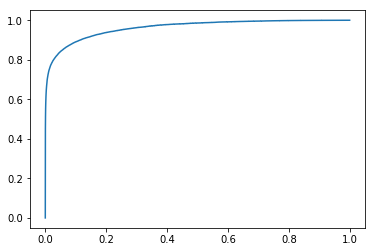

In [90]:
plt.plot(fpr, tpr)

In [91]:
auc(fpr, tpr)

0.962035223070915

In [84]:
test = pd.read_csv('test_transaction.csv')

In [85]:
test_id = pd.read_csv('test_identity.csv')

In [92]:
test = pd.merge(test, test_id, how='left', on='TransactionID')

In [93]:
#Dealing with NA
test.fillna(0, inplace=True)
#Variable Creation
test['has_r'] = (pd.notna(test['R_emaildomain'])).astype(int)
test['different_r'] = (test['has_r']) * (test.P_emaildomain == test.R_emaildomain).astype(int)
test['is_discover'] = (test.card4=='discover').astype(int)
test['is_credit'] = (test.card6=='credit').astype(int)
test['is_sketchy_addr2'] = (test.addr2.isin([0,60,96]))
test['is_na_M1'] = (test['M1']==0).astype(int)
test['is_na_M2'] = (test['M2']==0).astype(int)
test['is_na_M3'] = (test['M3']==0).astype(int)
test['is_na_M5'] = (test['M5']==0).astype(int)
test['is_na_M6'] = (test['M6']==0).astype(int)
test['is_na_M7'] = (test['M7']==0).astype(int)
test['is_na_M8'] = (test['M8']==0).astype(int)
test['is_na_M9'] = (test['M9']==0).astype(int)
test['is_big_NA'] = test['is_na_M1']*test['is_na_M2']*test['is_na_M3']*test['is_na_M5']*test['is_na_M6']*test['is_na_M7']*test['is_na_M8']*test['is_na_M9']
test['is_C'] = (test.ProductCD=='C').astype(int)
test['is_S'] = (test.ProductCD=='S').astype(int)
test['is_H'] = (test.ProductCD=='H').astype(int)
test['is_mobile'] = (test.DeviceType=='mobile').astype(int)
test['is_sketchy_device'] = (test.DeviceInfo.isin(sketchy_devices)).astype(int)
test['is_sketchy_browser'] = (test.id_31.isin(sketchy_browser)).astype(int)
test['is_protonmail'] = (test.P_emaildomain=='protonmail.com').astype(int)
test['is_elsewise_sketchy_email'] = (test.P_emaildomain.isin(['mail.com', 'outlook.es', 'aim.com', 'outlook.com']))
test['is_match'] = (test.id_34=='match_status:1').astype(int)
test['is_M4M2'] = (test['M4']=='M2').astype(int)
test['is_M3'] = (test['M3']=='T').astype(int)
test['is_M2'] = (test['M2']=='T').astype(int)
test['is_M9'] = (test['M9']=='T').astype(int)
test['is_no_info'] = (test.DeviceType==0).astype(int)


In [110]:
smaller_v_test = pd.DataFrame(pca1.transform(test[pcaCols])[:, 0:40])
smaller_v_test.columns = ['pca_'+str(a) for a in smaller_v_test.columns]

In [111]:
test2 = pd.concat([test, smaller_v_test], axis=1)

In [117]:
test2['preds'] = xgb_clf2.predict_proba(test2[cols])[:, 1]

In [118]:
submission_df = pd.DataFrame({'TransactionID':test2['TransactionID'], 'isFraud': test2['preds']})

In [119]:
submission_df.to_csv('submission_5.csv', index=False)